In [27]:
import os
import csv

# Paths to the images and points directories
image_folder = 'FGNET/images'   # Replace with actual path to the images folder
points_folder = 'FGNET/points' 

# CSV output file path
csv_output_file = 'train.csv'

# Define the header for the CSV
csv_header = ['image_file', 'age'] + [f'pts_{i:02d}_x' for i in range(1, 69)] + [f'pts_{i:02d}_y' for i in range(1, 69)]

# Function to read points from the points file
def read_points_file(points_file):
    with open(points_file, 'r') as f:
        lines = f.readlines()
        points = [tuple(map(float, line.split())) for line in lines if line.strip().replace('.', '', 1).isdigit()]
    return points

# Function to extract age from the image file name
def extract_age(image_file):
    return int(image_file[4:6])

# Create and write to the CSV file
with open(csv_output_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(csv_header)

    # Iterate over the image files
    for image_file in os.listdir(image_folder):
        if image_file.endswith('.JPG'):  # Only process .JPG files
            image_path = os.path.join(image_folder, image_file)
            
            # Extract the age from the image file name
            age = extract_age(image_file)
            
            # Find the corresponding points file
            points_file = os.path.join(points_folder, image_file.replace('.JPG', '.pts'))  # Assuming same name but .pts extension
            
            if os.path.exists(points_file):
                # Read points from the points file
                points = read_points_file(points_file)
                
                # Flatten the points list (X and Y) to match the header format
                flat_points = [coord for point in points for coord in point]
                
                # Write the row to the CSV
                writer.writerow([image_file, age] + flat_points)


# Multi-task Vision Transformer model

In [11]:
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import keras
from keras import ops
import pandas as pd
import numpy as np
import random

# Model configuration

In [12]:
# Dataset values
IMAGE_SIZE = 384

# Model configs
patch_size = 32
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)  # input image shape
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 50
num_patches = (IMAGE_SIZE // patch_size) ** 2
projection_dim = 64
num_heads = 4
age_k = 3

# Transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4

# MLP units
mlp_head_units = [2048, 1024, 512, 64, 32]


# FaceVit losses and metrics
facevit_losses = {
    "age": keras.losses.MeanSquaredError(),
}

facevit_metrics = {
    "age": [keras.metrics.MeanAbsoluteError()],
}

def model_compiler(model, optimizer, loss, metrics):
    "Model compilation function"
    model.compile(optimizer= optimizer, loss= loss, metrics = metrics)
    return model

# Load and prepare dataset

### Pre-processing

In [15]:
def create_age_bins_and_encode(df,
                               bin_size=2,
                               max_age = 100,
                               json_output_path='age/age_bins.json',
                               write_json = True):
    """
    Function to bin ages into configurable intervals, encode the bins, and save the encoding dictionary in JSON format.

    Parameters:
    df (pd.DataFrame): DataFrame containing the age column.
    bin_size (int): Size of each age bin (default is 5 years).
    json_output_path (str): Path to save the JSON dictionary mapping age bins to encoded labels.

    Returns:
    pd.DataFrame: DataFrame with an additional column for encoded age bins.
    """
    import json
    from sklearn.preprocessing import LabelEncoder

    # Define the age bins and bin labels
    bins = range(0, max_age, bin_size)
    labels = [f'{i}-{i + bin_size - 1}' for i in range(0, max_age- bin_size, bin_size)]

    # Bin the ages
    df['age_bin'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

    # Encode the age bins into class indexes
    label_encoder = LabelEncoder()
    df['age_class'] = label_encoder.fit_transform(df['age_bin'])
    age_bin_mapping = dict(zip(df['age_bin'], df['age_class']))

    # Save the dictionary as a JSON file
    if write_json:
        with open(json_output_path, 'w') as json_file:
            json.dump(age_bin_mapping, json_file)

    return df, len(age_bin_mapping)

### Augmentations pipeline

In [16]:
def apply_color_augmentation(image):
    augmentations = [
        lambda img: tf.image.random_brightness(img, max_delta=0.2),
        lambda img: tf.image.random_contrast(img, lower=0.5, upper=1.5),
        lambda img: tf.image.random_saturation(img, lower=0.5, upper=1.5),
        lambda img: tf.image.random_hue(img, max_delta=0.2)
    ]

    # Randomly select 2 augmentations to apply
    chosen_augmentations = random.sample(augmentations, 2)

    for aug in chosen_augmentations:
        image = aug(image)

    # Ensure values remain within 0 and 1
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image

def apply_augmentations_fn(images, ground_truth):
    """Only color based augmentatios are used for simplicity"""
    # Apply some simple color augmentations to the images
    augmented_images = tf.map_fn(apply_color_augmentation, images)
    return augmented_images, ground_truth

### Dataset builder

In [17]:
import pandas as pd
import tensorflow as tf

def create_tf_dataset(csv_file, images_dir, batch_size, target_size=(384, 384), augment=False, write_json=True):
    # Read the CSV file
    df = pd.read_csv(csv_file)

    # Debugging: Check the shape and columns of the DataFrame
    # print("Shape of DataFrame: ", df.shape)
    # print("Available columns: ", df.columns)

    # Define the points columns dynamically
    pts_columns = [f'pts_{i:02d}_x' for i in range(1, 69)] + [f'pts_{i:02d}_y' for i in range(1, 69)]

    # Ensure the columns exist
    if 'image_file' not in df.columns:
        raise ValueError("The 'image_file' column is missing from the CSV.")
    if 'age' not in df.columns:
        raise ValueError("The 'age' column is missing from the CSV.")
    
    # Add the specified columns
    df['image_file'] = images_dir + '/' + df['image_file']
    required_columns = ['image_file']  
    age_column = ['age']  

    # Final list of columns combining the specified ones and the generated points columns
    final_columns = required_columns + pts_columns + age_column

    # Check if all the required columns are in the DataFrame
    missing_columns = [col for col in final_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Missing columns in DataFrame: {missing_columns}")

    # Select only the final columns from the DataFrame
    df = df[final_columns]

    # Create the age bin with bins per 4 years for classification task
    df, num_age_groups = create_age_bins_and_encode(df, bin_size=2, write_json=write_json)

    # Ensure num_age_groups is an int32
    num_age_groups = int(num_age_groups)

    def load_and_preprocess_image(img_path, age):
        # Load image
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)

        # Resize and normalize
        img = tf.image.resize(img, target_size)
        img = tf.cast(img, tf.float32) / 255.0

        # Convert age to tensors
        age_tensor = tf.cast(tf.convert_to_tensor(age), dtype=tf.int32)
        age_tensor = tf.one_hot(age_tensor, depth=num_age_groups)

        # Debugging: Print shapes

        return img, age_tensor

    # Create TensorFlow dataset from DataFrame
    dataset = tf.data.Dataset.from_tensor_slices((
        df['image_file'].values, 
        df['age'].values
    ))

    # Load and preprocess images in parallel
    dataset = dataset.map(lambda img_path, age: load_and_preprocess_image(img_path, age), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Batch the dataset
    dataset = dataset.batch(batch_size, drop_remainder=True)

    if augment:
        dataset = dataset.map(apply_augmentations_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    return dataset, num_age_groups


# Splits

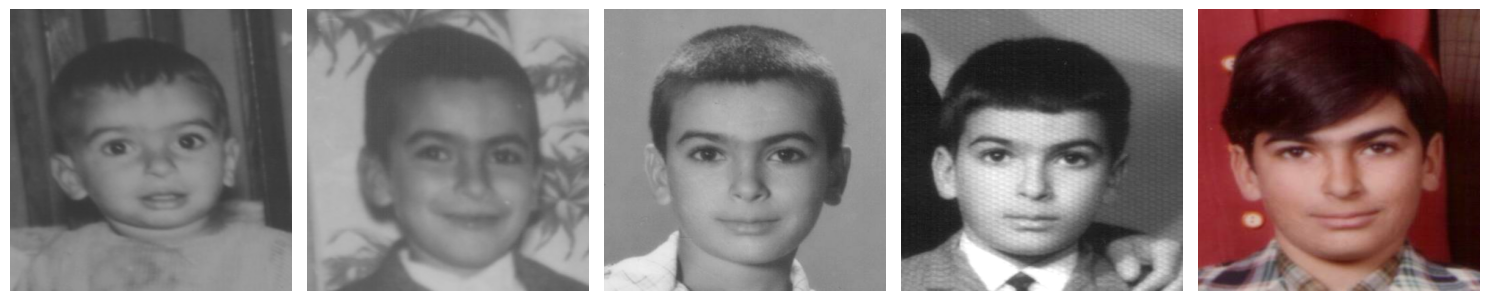

In [18]:
# Define paths and parameters
train_csv = 'FGNET/train.csv'
images_dir = 'FGNET/train'


# Create the dataset
train_dataset, num_age_groups = create_tf_dataset(train_csv, images_dir, batch_size, augment= True)


# Example usage (iterating over the dataset)
for batch in train_dataset:
    images, y_true = batch
    ages = y_true

    

    # Plot the first five images and their corresponding ages
    plt.figure(figsize=(15, 10))
    for i in range(5):
        img = images[i].numpy()
        img = (img * 255).astype('uint8')  # Convert back to uint8 for display

        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        # plt.title(f'Age: {tf.argmax(ages[i]).numpy()}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    break

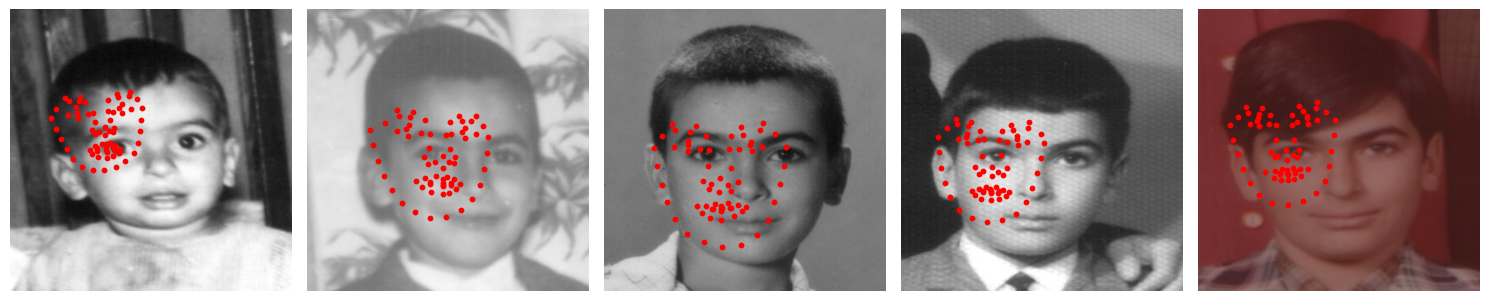

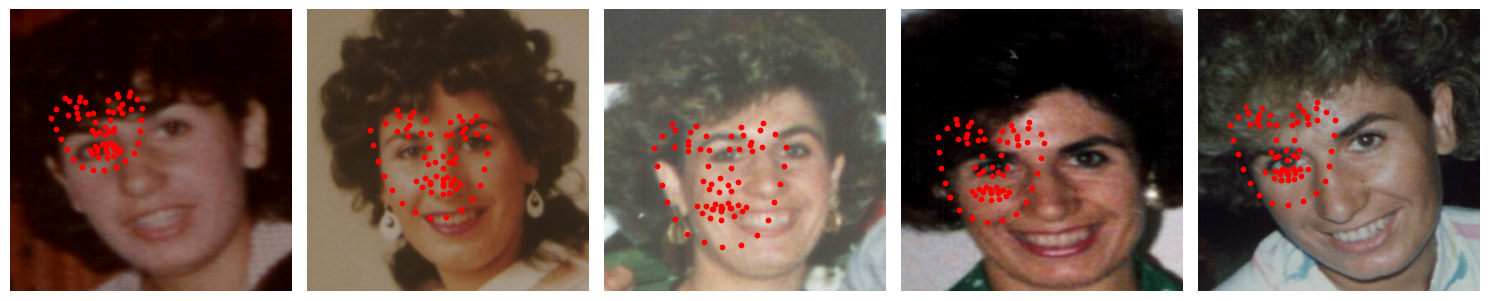

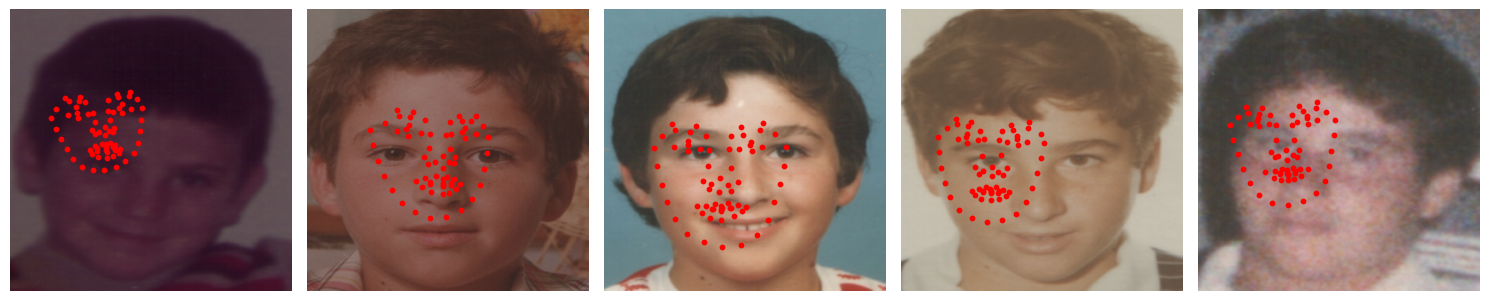

In [19]:
train_csv = 'FGNET/train.csv'
images_dir = 'FGNET/train'


# Create the dataset
train_dataset, num_age_groups = create_tf_dataset(train_csv, images_dir, batch_size, augment= True)

# Example usage (iterating over the dataset)
for batch in train_dataset:
    images, y_true = batch
    ages = y_true

    # Get the points (landmarks) for the first batch
    points = df.iloc[0:batch_size, 1:-1].values  # Adjust index as needed (1:-1 to exclude image_file and age)

    # Define the original dimensions of the images the points were based on
    original_img_size = (384, 384)  # This size might vary; adjust accordingly based on your data

    # Plot the first five images, their corresponding ages, and points
    plt.figure(figsize=(15, 10))
    for i in range(5):
        img = images[i].numpy()
        img = (img * 255).astype('uint8')  # Convert back to uint8 for display

        # Current image dimensions (284x284)
        current_img_size = (284, 284)
        
        # Calculate scaling factors
        scale_x = current_img_size[1] / original_img_size[1]
        scale_y = current_img_size[0] / original_img_size[0]

        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')

        # Plot landmarks with scaling
        for j in range(0, len(points[i]), 2):  # Step by 2 to get x and y coordinates
            x = points[i][j] * scale_x  # Scale the x-coordinate
            y = points[i][j + 1] * scale_y  # Scale the y-coordinate
            plt.scatter(x, y, color='red', s=10)  # Plot the point

    plt.tight_layout()
    plt.show()

    # break


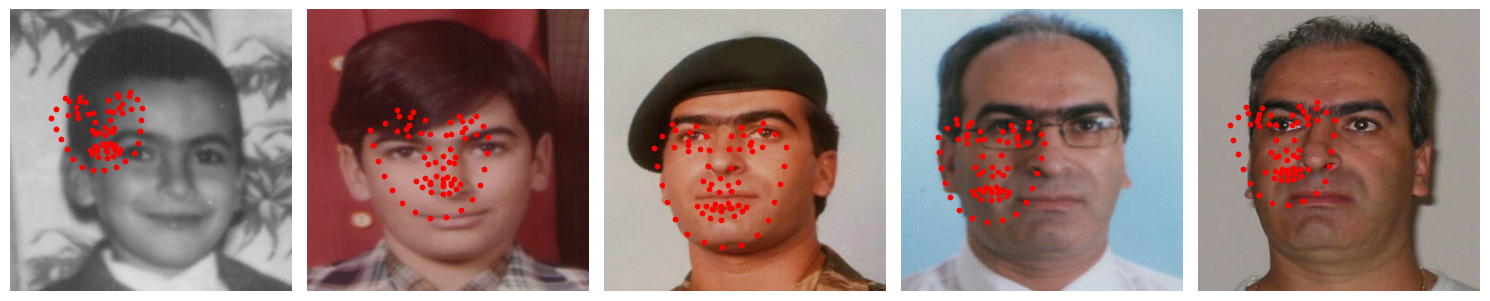

In [34]:
# Define paths and parameters
val_csv = 'FGNET/test.csv'
images_dir = 'FGNET/test'

# Create the dataset
val_dataset, _ = create_tf_dataset(val_csv, images_dir, batch_size, write_json = False)

# Example usage (iterating over the dataset)
for batch in val_dataset:
    images, y_true = batch
    ages = y_true

    # Get the points (landmarks) for the first batch
    points = df.iloc[0:batch_size, 1:-1].values  # Adjust index as needed (1:-1 to exclude image_file and age)

    # Define the original dimensions of the images the points were based on
    original_img_size = (384, 384)  # This size might vary; adjust accordingly based on your data

    # Plot the first five images, their corresponding ages, and points
    plt.figure(figsize=(15, 10))
    for i in range(5):
        img = images[i].numpy()
        img = (img * 255).astype('uint8')  # Convert back to uint8 for display

        # Current image dimensions (284x284)
        current_img_size = (284, 284)
        
        # Calculate scaling factors
        scale_x = current_img_size[1] / original_img_size[1]
        scale_y = current_img_size[0] / original_img_size[0]

        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')

        # Plot landmarks with scaling
        for j in range(0, len(points[i]), 2):  # Step by 2 to get x and y coordinates
            x = points[i][j] * scale_x  # Scale the x-coordinate
            y = points[i][j + 1] * scale_y  # Scale the y-coordinate
            plt.scatter(x, y, color='red', s=10)  # Plot the point

    plt.tight_layout()
    plt.show()

    break

# FaceVit model 

In [22]:
def mlp(x, hidden_units, dropout_rate, block_name):
    """Simple MLP with dropout"""
    for i in range(len(hidden_units)):
        x = layers.Dense(hidden_units[i], activation=keras.activations.gelu, name= f'Dense_{i}_{block_name}')(x)
        x = layers.Dropout(dropout_rate, name = f'Dropout_{i}_{block_name}')(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size, name):
        super().__init__()
        self.patch_size = patch_size
        self.name = name

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size,
                       'name': self.name})
        return config

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, name):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.name = name

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded
    
class Class_Embeddings(layers.Layer):
    def __init__(self, projection_dim, name=None):
        super(Class_Embeddings, self).__init__(name=name)
        self.projection_dim = projection_dim
        self.age_cls_embedding = self.add_weight(
            shape=(1, 1, projection_dim),
            initializer='random_normal',
            trainable=True,
            name='age_cls_embedding'
        )
        

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        age_cls_embedding = tf.tile(self.age_cls_embedding, [batch_size, 1, 1])
        return age_cls_embedding



def build_facevit(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
    age_bins_num
):
    inputs = keras.Input(shape=input_shape, name = 'Input')

    # Create patches
    patches = Patches(patch_size, name = 'Patch_creator')(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim, name ='Patch_encoder')(patches)

    # Create the class tokens for the classification tasks
    class_tokens = Class_Embeddings(projection_dim, name='Class_Encoder')
    age_cls_embedding = class_tokens(inputs)

    # Pre-pend the tokens to the encoded_patches (age )
    encoded_patches = layers.Concatenate(axis=1, name= 'embed_concat')([age_cls_embedding, encoded_patches])

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6, name = f'LayerNorm_1_block_{i}')(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1, name = f'MultiHeadAttn_block_{i}'
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add(name = f'Skip_1_block_{i}')([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6, name = f'LayerNorm_2_block_{i}')(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1, block_name = f'trans_block_{i}')
        # Skip connection 2.
        encoded_patches = layers.Add(name = f'Skip_2_block_{i}')([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6, name ='LayerNorm_transformed')(encoded_patches)
    representation = layers.Flatten(name = 'Flatten_transformed')(representation[:, 2:, :])
    representation = layers.Dropout(0.3, name = 'Dropout_transformed')(representation)

    # Get the transformed class/age tokens for the classifation tasks
    age_token = encoded_patches[:, 0, :]   

    # Add MLP.
    features_age = mlp(age_token, hidden_units=mlp_head_units, dropout_rate=0.3, block_name= 'MLP_age_out')

    # FaceViT output layers
    age_classifier = layers.Dense(age_bins_num, activation= 'softmax', name= 'age') (features_age)

    return keras.Model(inputs=inputs, outputs=[age_classifier], name = 'FaceVit')

In [23]:
model = build_facevit(input_shape,
                      patch_size,
                      num_patches,
                      projection_dim,
                      num_heads,
                      transformer_units,
                      transformer_layers,
                      mlp_head_units,
                      num_age_groups
                    )
model.summary()

Model: "FaceVit"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 384, 384,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Patch_creator       │ (None, 144, 3072) │          0 │ Input[0][0]       │
│ (Patches)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Class_Encoder       │ (None, 1, 64)     │         64 │ Input[0][0]       │
│ (Class_Embeddings)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Patch_encoder       │ (None, 144, 64)   │    205,888 │ Patch_creator[0]… │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_concat        │ (None, 145, 64)   │          0 │ Class_Encoder[0]… │
│ (Concatenate)       │                   │            │ Patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LayerNorm_1_block_0 │ (None, 145, 64)   │        128 │ embed_concat[0][… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MultiHeadAttn_bloc… │ (None, 145, 64)   │     66,368 │ LayerNorm_1_bloc… │
│ (MultiHeadAttentio… │                   │            │ LayerNorm_1_bloc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Skip_1_block_0      │ (None, 145, 64)   │          0 │ MultiHeadAttn_bl… │
│ (Add)               │                   │            │ embed_concat[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LayerNorm_2_block_0 │ (None, 145, 64)   │        128 │ Skip_1_block_0[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_0_trans_bloc… │ (None, 145, 128)  │      8,320 │ LayerNorm_2_bloc… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_0_trans_bl… │ (None, 145, 128)  │          0 │ Dense_0_trans_bl… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_1_trans_bloc… │ (None, 145, 64)   │      8,256 │ Dropout_0_trans_… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_1_trans_bl… │ (None, 145, 64)   │          0 │ Dense_1_trans_bl… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Skip_2_block_0      │ (None, 145, 64)   │          0 │ Dropout_1_trans_… │
│ (Add)               │                   │            │ Skip_1_block_0[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LayerNorm_1_block_1 │ (None, 145, 64)   │        128 │ Skip_2_block_0[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MultiHeadAttn_bloc… │ (None, 145, 64)   │     66,368 │ LayerNorm_1_bloc… │
│ (MultiHeadAttentio… │                   │            │ LayerNorm_1_bloc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Skip_1_block_1      │ (None, 145, 64)   │          0 │ MultiHeadAttn_bl

 Total params: 3,330,849 (12.71 MB)

 Trainable params: 3,330,849 (12.71 MB)

 Non-trainable params: 0 (0.00 B)

# Test patches layer

Image size: 384 X 384
Patch size: 32 X 32
144 patches per image 
3072 elements per patch


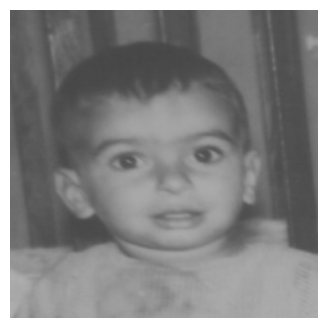

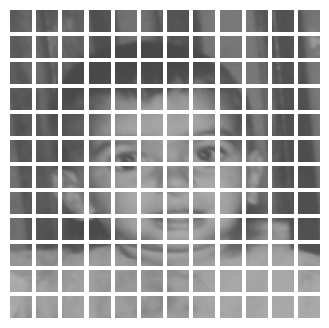

In [24]:
batch = next(iter(train_dataset))
images, _ = batch
image = images[0] * 255
image = image.numpy()

plt.figure(figsize=(4, 4))
plt.imshow(image.astype("uint8"))
plt.axis("off")

patches = Patches(patch_size, name= 'Patches')(np.expand_dims(image, axis=0))
print(f"Image size: {IMAGE_SIZE} X {IMAGE_SIZE}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")


n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

# Training function

In [13]:
def run_experiment(model, 
                   train_ds, 
                   validation_ds, 
                   learning_rate, 
                   weight_decay,
                   batch_size, 
                   num_epochs,
                   loss_func,
                   metrics):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # Compile model.
    model = model_compiler(model, optimizer, loss= loss_func, metrics= metrics)

    checkpoint_filepath = "checkpoints/facevit.weights.h5"

    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        train_ds,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=validation_ds,
        callbacks=[
            checkpoint_callback,
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
        ]
    )

    return history

# Train model
history = run_experiment(
    model,
    train_dataset,
    val_dataset,
    learning_rate, 
    weight_decay, 
    batch_size, 
    num_epochs,
    facevit_losses,
    facevit_metrics
)

Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 87s 19s/step - age_loss: 0.6408 - age_top_3_accuracy: 0.3379 - face_loss: 0.4088 - face_mse: 0.1380 - gender_accuracy: 0.4832 - gender_loss: 0.2502 - loss: 1.2999 - val_age_loss: 0.5326 - val_age_top_3_accuracy: 0.2480 - val_face_loss: 0.3508 - val_face_mse: 0.3558 - val_gender_accuracy: 0.4766 - val_gender_loss: 0.2554 - val_loss: 1.1387
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 130s 25s/step - age_loss: 0.5509 - age_top_3_accuracy: 0.2824 - face_loss: 0.4166 - face_mse: 0.3186 - gender_accuracy: 0.4827 - gender_loss: 0.2561 - loss: 1.2237 - val_age_loss: 0.5008 - val_age_top_3_accuracy: 0.2266 - val_face_loss: 0.3507 - val_face_mse: 0.3562 - val_gender_accuracy: 0.4766 - val_gender_loss: 0.2511 - val_loss: 1.1026
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 64s 17s/step - age_loss: 0.5201 - age_top_3_accuracy: 0.3212 - face_loss: 0.4050 - face_mse: 0.3418 - gender_accuracy: 0.5036 - gender_loss: 0.2518 - loss: 1.1769 - val_age_loss: 0.4120 - val_age_top_3_accurac

In [ ]:
 # Save the model as a .h5 file
model_save_path = "checkpoints/facevit_model.h5"
model.save(model_save_path)

# Plot loss

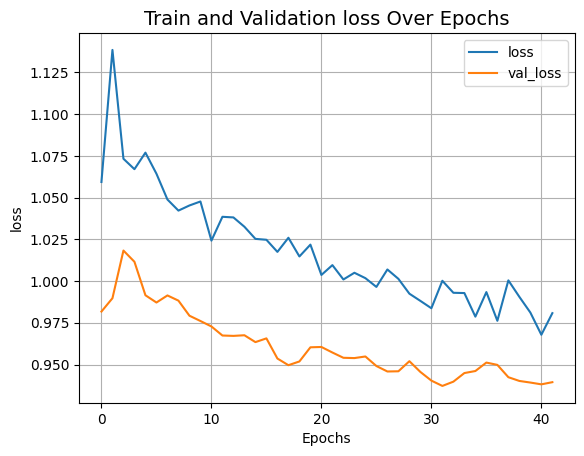

In [19]:
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

plot_history("loss")

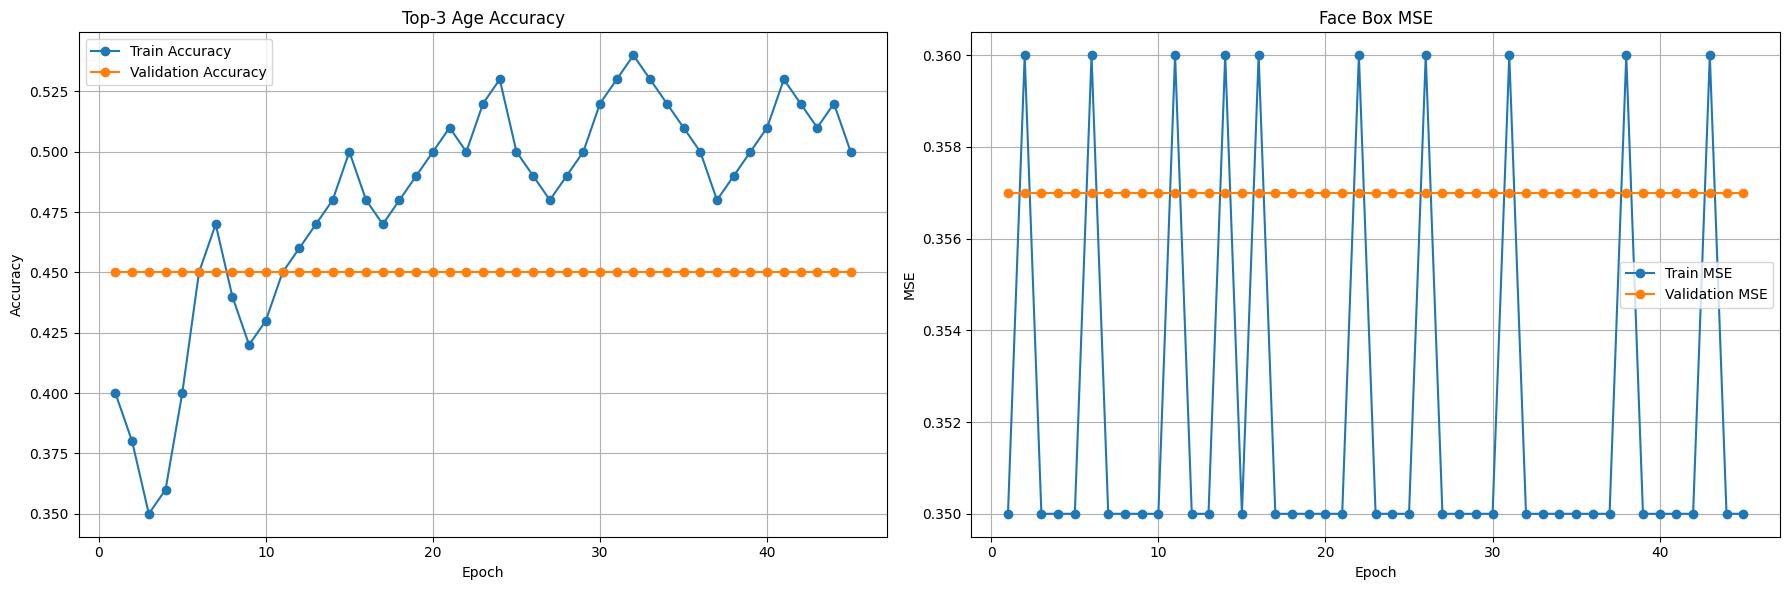

In [42]:
def plot_metrics(history):
    history = history.history
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot age accuracy
    axes[0].plot(history[f'age_top_{age_k}_accuracy'], label='Train Accuracy', marker='o')
    axes[0].plot(history[f'val_age_top_{age_k}_accuracy'], label='Validation Accuracy', marker='o')
    axes[0].set_title(f'Top-{age_k} age Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    # Plot face mse
    axes[1].plot(history['face_mse'], label='Train MSE', marker='o')
    axes[1].plot(history['val_face_mse'], label='Validation MSE', marker='o')
    axes[1].set_title('Face box MSE')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MSE')
    axes[1].legend()
    axes[1].grid(True)


    plt.tight_layout()
    plt.show()

plot_metrics(history)


# Test

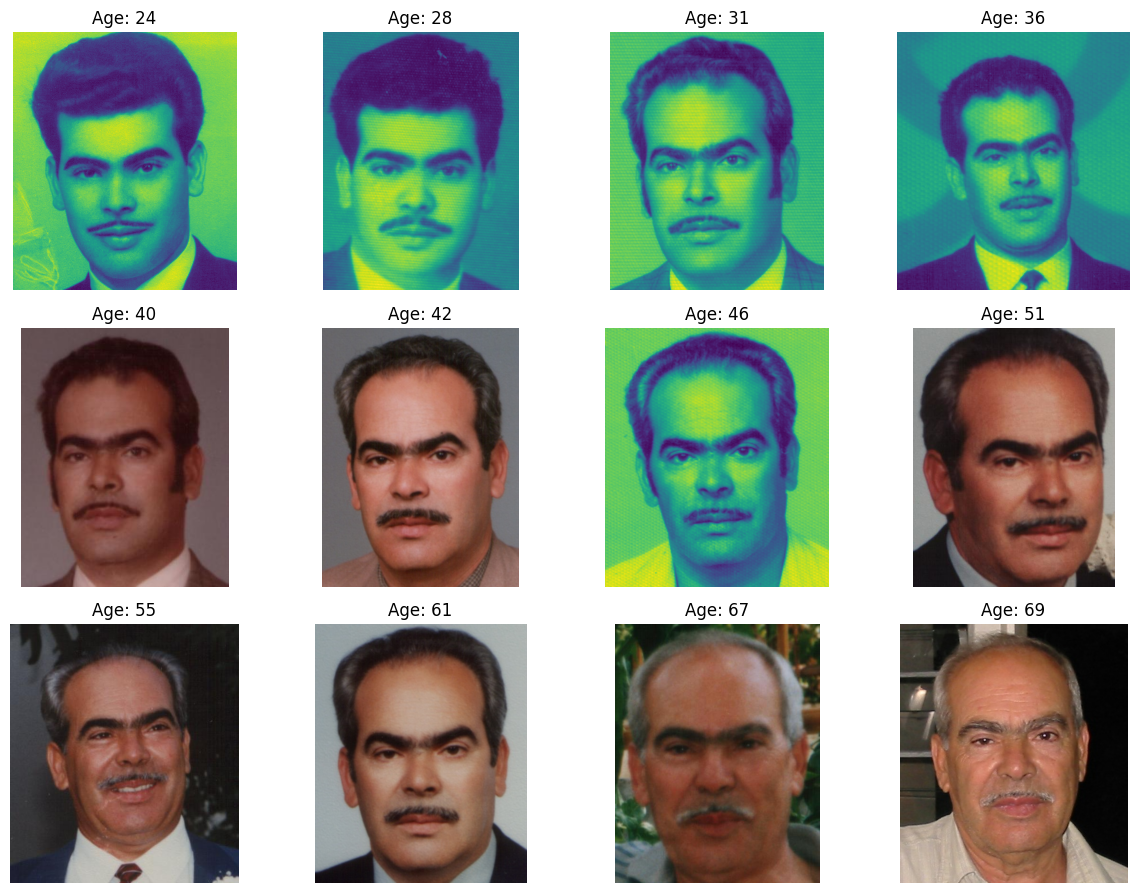

In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import json
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load the trained model
model = "checkpoints/facevit_model.h5"
model = build_facevit(
    input_shape,          # Define the input shape
    patch_size,           # Define the patch size
    num_patches,          # Define the number of patches
    projection_dim,       # Define the projection dimension
    num_heads,            # Define the number of attention heads
    transformer_units,    # Define the transformer units
    transformer_layers,   # Define the number of transformer layers
    mlp_head_units,       # Define the MLP head units
    num_age_groups        # Define the number of age groups
)


# Define paths and uploaded image
image_directory = 'FGNET/images'  # Replace with the actual path to your images
csv_file_path = 'FGNET/train.csv'   # Replace with your CSV file path
age_bins_file = 'age/age_bins.json'  # Path to the JSON file with age bins

# Example of an uploaded image
# uploaded_image = "011A17.JPG"
uploaded_image = "006A24.JPG"
# uploaded_image = "010A06.JPG"
# uploaded_image = "009A22b.JPG"

# Load CSV and image filenames
df = pd.read_csv(csv_file_path)
csv_image_filenames = df['image_file'].tolist()

# Load the age bin data from JSON
with open(age_bins_file, 'r') as f:
    age_bins = json.load(f)
extract_digits = lambda x: x[1:3]
extract_age = lambda x: int(x[4:6])

# Function to find the appropriate age bin
def get_age_bin(age):
    for age_range, bin_number in age_bins.items():
        age_min, age_max = map(int, age_range.split('-'))
        if age_min <= age <= age_max:
            return bin_number
    return None

# Filter images based on the uploaded image
uploaded_digits = extract_digits(uploaded_image)
filtered_images = [img for img in csv_image_filenames if extract_digits(img) == uploaded_digits]

# Add the uploaded image if it's not already in the filtered list
if uploaded_image not in filtered_images:
    filtered_images.append(uploaded_image)

# Display images with ages and bins using matplotlib
plt.figure(figsize=(12, len(filtered_images) // 4 * 4))

for idx, img_name in enumerate(filtered_images):
    img_path = os.path.join(image_directory, img_name)
    if os.path.exists(img_path):
        # Open the image
        img = Image.open(img_path)

        # Extract age from the image filename and find the corresponding age bin
        age = extract_age(img_name)
        age_bin = get_age_bin(age)
        
        # Display the image and the age information
        plt.subplot(len(filtered_images) // 4 + 1, 4, idx + 1)
        plt.imshow(img)
        plt.title(f"Age: {age}")
        plt.axis('off')

plt.tight_layout()
plt.show()


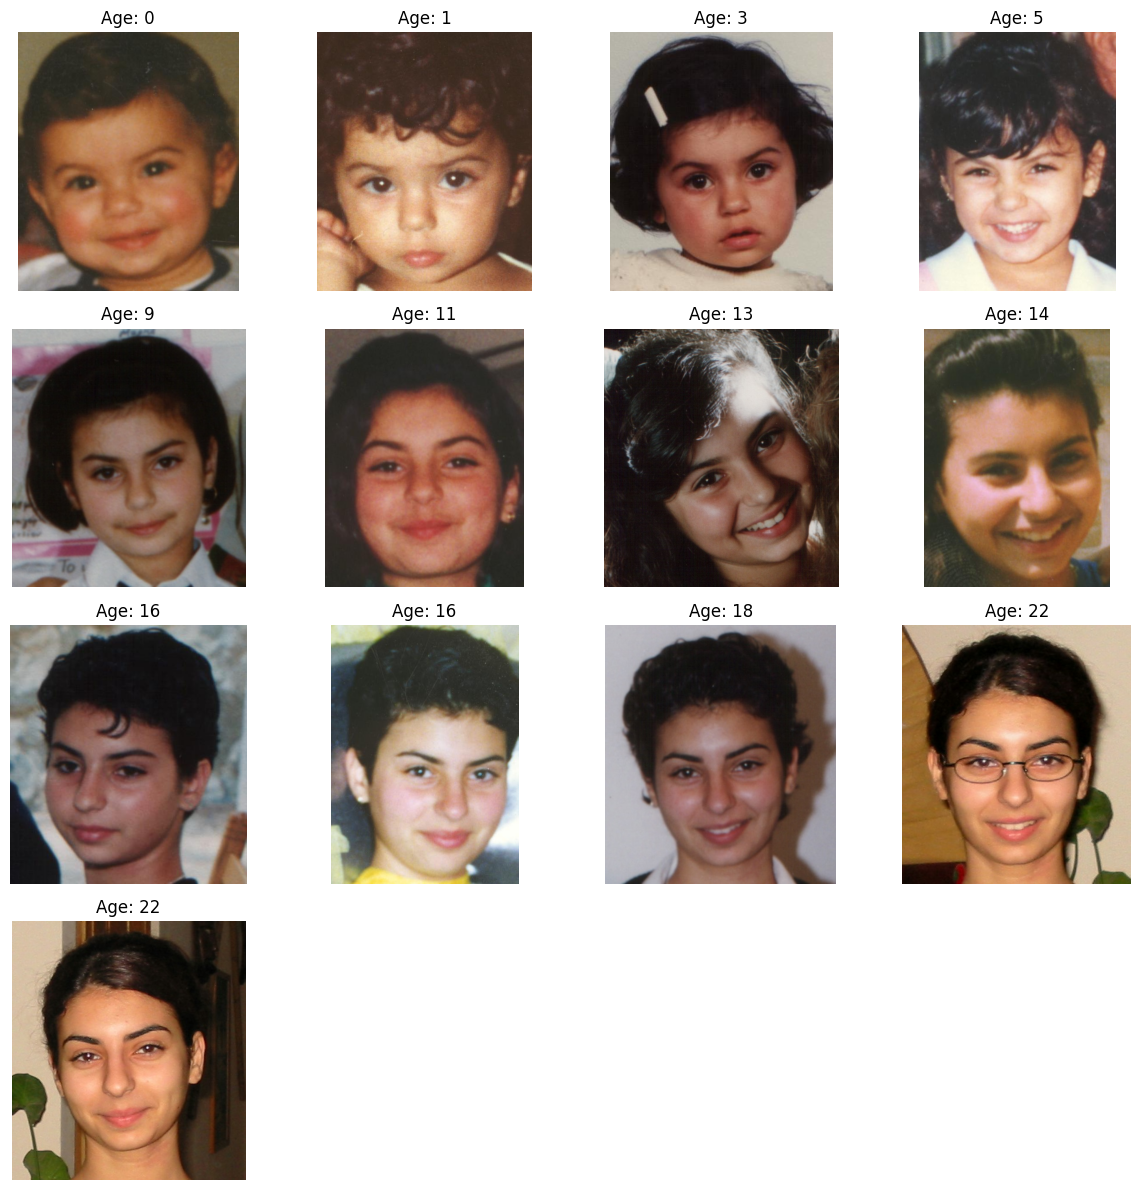

In [25]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import json
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load the trained model
model = "checkpoints/facevit_model.h5"
model = build_facevit(
    input_shape,          # Define the input shape
    patch_size,           # Define the patch size
    num_patches,          # Define the number of patches
    projection_dim,       # Define the projection dimension
    num_heads,            # Define the number of attention heads
    transformer_units,    # Define the transformer units
    transformer_layers,   # Define the number of transformer layers
    mlp_head_units,       # Define the MLP head units
    num_age_groups        # Define the number of age groups
)

# Define paths and uploaded image
image_directory = 'FGNET/images'  # Replace with the actual path to your images
csv_file_path = 'FGNET/train.csv'   # Replace with your CSV file path
age_bins_file = 'age/age_bins.json'  # Path to the JSON file with age bins

# Example of an uploaded image
# uploaded_image = "011A17.JPG"
# uploaded_image = "006A24.JPG"
# uploaded_image = "010A06.JPG"
uploaded_image = "009A22b.JPG"

# Load CSV and image filenames
df = pd.read_csv(csv_file_path)
csv_image_filenames = df['image_file'].tolist()

# Load the age bin data from JSON
with open(age_bins_file, 'r') as f:
    age_bins = json.load(f)
extract_digits = lambda x: x[1:3]
extract_age = lambda x: int(x[4:6])

# Function to find the appropriate age bin
def get_age_bin(age):
    for age_range, bin_number in age_bins.items():
        age_min, age_max = map(int, age_range.split('-'))
        if age_min <= age <= age_max:
            return bin_number
    return None

# Filter images based on the uploaded image
uploaded_digits = extract_digits(uploaded_image)
filtered_images = [img for img in csv_image_filenames if extract_digits(img) == uploaded_digits]

# Add the uploaded image if it's not already in the filtered list
if uploaded_image not in filtered_images:
    filtered_images.append(uploaded_image)

# Display images with ages and bins using matplotlib
plt.figure(figsize=(12, len(filtered_images) // 4 * 4))

for idx, img_name in enumerate(filtered_images):
    img_path = os.path.join(image_directory, img_name)
    if os.path.exists(img_path):
        # Open the image
        img = Image.open(img_path)

        # Extract age from the image filename and find the corresponding age bin
        age = extract_age(img_name)
        age_bin = get_age_bin(age)
        
        # Display the image and the age information
        plt.subplot(len(filtered_images) // 4 + 1, 4, idx + 1)
        plt.imshow(img)
        plt.title(f"Age: {age}")
        plt.axis('off')

plt.tight_layout()
plt.show()


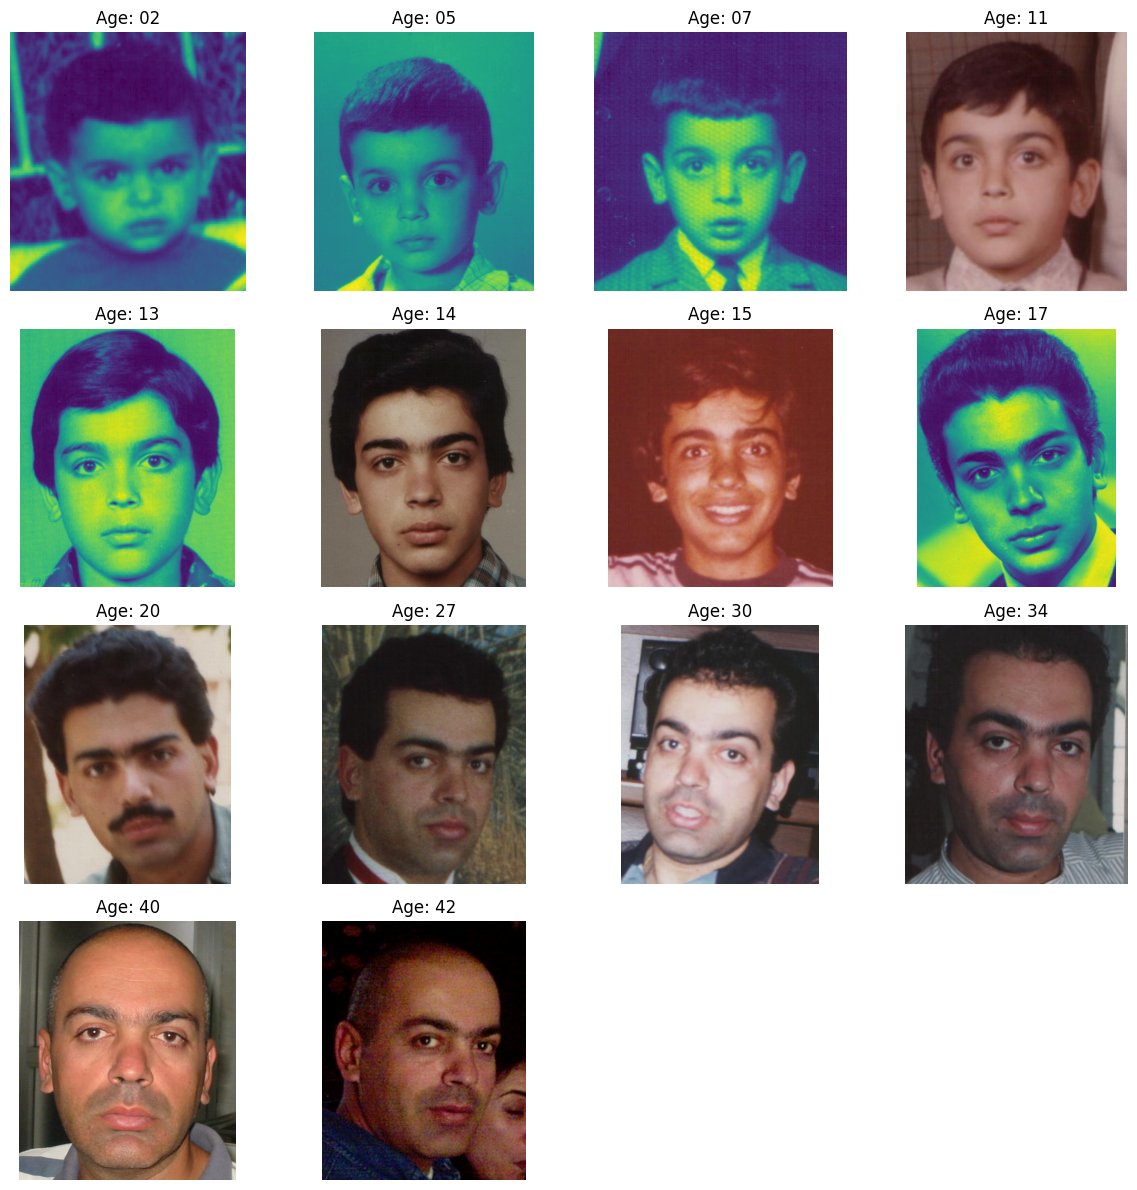

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Define paths and uploaded image
image_directory = 'FGNET/images'  # Replace with the actual path to your images
csv_file_path = 'updated_csv_file.csv'   # Replace with your CSV file path
# uploaded_image = "002A02.JPG"  # Uploaded image example

# uploaded_image = "002A02.JPG"  # Example of an uploaded image
# uploaded_image = "006A24.JPG"
# uploaded_image = "010A06.JPG"
# uploaded_image = "009A22b.JPG"
uploaded_image = "011A17.JPG"
# Load CSV and image filenames
df = pd.read_csv(csv_file_path)
csv_image_filenames = df['image_file'].tolist()

# Extract digits and age from filename
extract_digits = lambda x: x[1:3]
extract_age = lambda x: x[4:6]

# Filter and add the uploaded image if not in the list
uploaded_digits = extract_digits(uploaded_image)
filtered_images = [img for img in csv_image_filenames if extract_digits(img) == uploaded_digits]
if uploaded_image not in filtered_images:
    filtered_images.append(uploaded_image)

# Display images with ages
plt.figure(figsize=(12, len(filtered_images) // 4 * 4))
for idx, img_name in enumerate(filtered_images):
    img_path = os.path.join(image_directory, img_name)
    if os.path.exists(img_path):
        img = Image.open(img_path)
        plt.subplot(len(filtered_images) // 4 + 1, 4, idx + 1)
        plt.imshow(img)
        plt.title(f"Age: {extract_age(img_name)}")
        plt.axis('off')
plt.tight_layout()
plt.show()
